In [1]:
from datetime import datetime
start_time = datetime.now()

# Load libraries


import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 3 minutes

LOAD DURATION: 0:00:02.273538


## Load Data

In [2]:
%%time
property_data = pd.read_csv('NY property data.csv')
NY_data_orig = property_data.copy()

CPU times: user 5.03 s, sys: 1.91 s, total: 6.94 s
Wall time: 7.02 s


## Explore data

In [3]:
property_data.shape

(1070994, 32)

In [4]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,DEPT OF GENERAL SERVI,DEPARTMENT OF BUSINES,PARKS AND RECREATION
BLDGCL,P7,Z9,Y7,T2,Q1
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,709,793,323


In [5]:
numrecs = len(property_data)

## Fill in missing ZIP

In [6]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

29890

In [7]:
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [8]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

16437

In [9]:
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [10]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [11]:
property_data['FULLVAL'].replace('NaN',0)
temp =property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.698435e+05
1A    3.352842e+05
1B    5.613639e+05
1C    7.615359e+05
1D    2.233614e+07
2     7.998018e+05
2A    8.640037e+05
2B    1.252989e+06
2C    7.728799e+05
3     1.112765e+05
4     3.211928e+06
Name: FULLVAL, dtype: float64


In [12]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [13]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [14]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

CPU times: user 4.65 s, sys: 36.2 ms, total: 4.69 s
Wall time: 4.69 s


In [15]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,DEPT OF GENERAL SERVI,DEPARTMENT OF BUSINES,PARKS AND RECREATION
BLDGCL,P7,Z9,Y7,T2,Q1
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,709,793,323


## STORIES

In [16]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

56264

In [17]:
temp['TAXCLASS'].value_counts()

1B    24736
4     22354
3      4635
2      3435
1       897
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [18]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111641
1A     1.656837
1B     4.000000
1C     3.052748
1D     1.068966
2     16.095110
2A     2.844574
2B     4.004494
2C     4.745097
3      1.333333
4      5.446968
Name: STORIES, dtype: float64


In [19]:
temp.head().transpose()

,0,1,5,65,66
RECORD,1,2,6,66,67
BBLE,1000010101,1000010201,1000030002,1000051004,1000051005
B,1,1,1,1,1
BLOCK,1,1,3,5,5
LOT,101,201,2,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,PARKS AND RECREATION,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT
BLDGCL,P7,Z9,Q1,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,496,0,0


In [20]:
len(property_data[property_data["STORIES"]==0])

0

In [21]:
property_data['STORIES']=property_data['STORIES'].fillna(value =0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]

In [22]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,DEPT OF GENERAL SERVI,DEPARTMENT OF BUSINES,PARKS AND RECREATION
BLDGCL,P7,Z9,Y7,T2,Q1
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,709,793,323


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [23]:
%%time
# calculate grouped average. replace 0,1 by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

#calculate mean
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

#impute values
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

CPU times: user 6.14 s, sys: 613 ms, total: 6.75 s
Wall time: 6.8 s


In [24]:
mean_LTFRONT

TAXCLASS
1      30.938800
1A     50.932905
1B     53.915753
1C     27.250825
1D    338.275862
2     113.243648
2A     25.917246
2B     27.254835
2C     29.987290
3     135.906790
4      93.587471
Name: LTFRONT, dtype: float64

In [25]:
mean_LTDEPTH

TAXCLASS
1      99.282387
1A     90.068015
1B    111.595937
1C     96.778878
1D    497.827586
2     132.606230
2A     97.282675
2B     95.751182
2C     95.737463
3     280.337008
4     133.775536
Name: LTDEPTH, dtype: float64

In [26]:
mean_BLDFRONT

TAXCLASS
1     21.400211
1A    25.010024
1B    39.500000
1C    23.367589
1D    19.586207
2     92.194711
2A    22.983862
2B    26.042747
2C    27.888318
3     19.333333
4     64.412214
Name: BLDFRONT, dtype: float64

In [27]:
mean_BLDDEPTH

TAXCLASS
1      41.554973
1A     44.922715
1B     82.666667
1C     60.094862
1D     36.862069
2     107.997728
2A     62.430662
2B     66.587020
2C     68.660429
3      33.750000
4      87.795565
Name: BLDDEPTH, dtype: float64

In [28]:
data = property_data.copy()
data.shape

(1070994, 32)

In [29]:
data.dtypes

RECORD        int64
BBLE         object
B             int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [30]:
# convert ZIP to an integer rather than a float
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [31]:
data.count()

RECORD      1070994
BBLE        1070994
B           1070994
BLOCK       1070994
LOT         1070994
EASEMENT       4636
OWNER       1039249
BLDGCL      1070994
TAXCLASS    1070994
LTFRONT     1070994
LTDEPTH     1070994
EXT          354305
STORIES     1070994
FULLVAL     1070994
AVLAND      1070994
AVTOT       1070994
EXLAND      1070994
EXTOT       1070994
EXCD1        638488
STADDR      1070318
ZIP         1070994
EXMPTCL       15579
BLDFRONT    1070994
BLDDEPTH    1070994
AVLAND2      282726
AVTOT2       282732
EXLAND2       87449
EXTOT2       130828
EXCD2         92948
PERIOD      1070994
YEAR        1070994
VALTYPE     1070994
zip3        1070994
dtype: int64

In [32]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


## Calculate lotarea, building area, building volume

In [33]:
#
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [34]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,DEPT OF GENERAL SERVI,DEPARTMENT OF BUSINES,PARKS AND RECREATION
BLDGCL,P7,Z9,Y7,T2,Q1
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,709,793,323


## Create varaibles

In [35]:
#Calculate the value per lotarea, building area, building volume
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [36]:
#
%%time
#Calculate the grouped averages of these 9 variables, grouped by zip5, zip3, taxclass, borough
ninevars = ['r1','r2','r3','r4','r5','r6','r7','r8','r9']
zip5_mean = data.groupby('ZIP')[ninevars].mean()
zip3_mean = data.groupby('zip3')[ninevars].mean()
taxclass_mean = data.groupby('TAXCLASS')[ninevars].mean()
borough_mean = data.groupby('B')[ninevars].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(zip3_mean, on='zip3', rsuffix='_zip3')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
data = data.join(borough_mean, on='B', rsuffix='_boro')
rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']
#Divide each of the 9 core variables by the 4 scale factors from these groupings
#Get the ratio compared to each group's average
for var in ninevars:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

CPU times: user 2.02 s, sys: 1.05 s, total: 3.07 s
Wall time: 3 s


In [37]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,3,4,5
BBLE,1000010101,1000010201,1000020001,1000020023,1000030001
B,1,1,1,1,1
BLOCK,1,1,2,2,3
LOT,101,201,1,23,1
...,...,...,...,...,...
r5_boro,11.7592,39.8236,1.53524,5.12605,375.527
r6_boro,6.07113,20.5604,1.43914,7.20773,1056.06
r7_boro,0.197696,259.238,1.26488,0.433458,3.23266
r8_boro,11.8183,107.027,0.817607,2.61395,167.635


In [38]:
data.columns

Index(['RECORD', 'BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_zip3', 'r2_zip3', 'r3_zip3',
       'r4_zip3', 'r5_zip3', 'r6_zip3', 'r7_zip3', 'r8_zip3', 'r9_zip3',
       'r1_taxclass', 'r2_taxclass', 'r3_taxclass', 'r4_taxclass',
       'r5_taxclass', 'r6_taxclass', 'r7_taxclass', 'r8_taxclass',
       'r9_taxclass', 'r1_boro', 'r2_boro', 'r3_boro', 'r4_boro', 'r5_boro',
       'r6_boro', 'r7_boro', 'r8_boro', 'r9_boro'],
      dtype='object')

In [39]:
dropcols = ['RECORD','BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1070994, 45)

In [40]:
data.head().transpose()

,0,1,2,3,4
r1,40.917782,53655.384245,261.796157,89.714219,669.074647
r2,3784.190253,34269.909866,261.796157,836.980890,53676.325646
r3,694.733351,6291.557172,87.265386,418.490445,53676.325646
r4,8.079350,3961.860416,97.551991,34.913021,297.434763
r5,747.200744,2530.456193,97.551991,325.717946,23861.620343
r6,137.177373,464.562348,32.517330,162.858973,23861.620343
r7,18.413002,24144.922910,117.808271,40.371399,301.083591
r8,1702.885614,15421.459440,117.808271,376.641401,24154.346541
r9,312.630008,2831.200728,39.269424,188.320700,24154.346541
r1_zip5,0.100267,131.479899,0.641519,0.219840,1.639535


In [41]:
stats = data.describe().transpose()
stats.to_csv('stats_on_vars.csv')

In [42]:
data.to_csv('NY vars.csv', index=False)
data.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,...,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,2.152278e+02,5.760426e+02,2.623124e+02,1.134086e+01,3.393744e+01,1.590520e+01,2.781460e+01,6.416045e+01,2.555350e+01,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,1.439696e+03,7.757851e+03,3.756499e+03,2.111728e+02,2.424134e+03,1.438070e+03,3.733010e+02,3.066847e+03,1.487748e+03,6.042822e+00,...,8.133147e+01,8.418100e+00,1.266710e+01,1.477032e+01,2.608965e+01,6.232079e+01,7.308819e+01,2.042847e+01,4.749950e+01,4.937404e+01
min,3.194961e-04,7.073253e-04,8.608601e-05,8.333333e-06,2.008674e-04,1.038033e-05,8.333333e-06,3.062474e-04,6.049251e-05,1.871600e-06,...,2.724933e-06,1.845598e-06,1.103987e-06,2.713139e-07,7.661991e-07,3.161191e-06,4.594072e-07,3.513719e-07,6.929921e-06,1.754849e-06
25%,7.115844e+01,1.705387e+02,6.884638e+01,2.238848e+00,5.607847e+00,1.736443e+00,5.137000e+00,1.671970e+01,6.573992e+00,4.115977e-01,...,3.466654e-01,3.814362e-01,3.121583e-01,2.775122e-01,2.167349e-01,1.953350e-01,1.227757e-01,2.284651e-01,2.911320e-01,2.829509e-01
50%,1.504507e+02,4.933333e+02,2.349206e+02,4.559750e+00,1.488000e+01,7.083636e+00,8.493884e+00,2.681687e+01,1.258945e+01,8.854000e-01,...,7.767597e-01,8.110334e-01,8.631789e-01,8.435327e-01,5.931468e-01,4.757397e-01,4.490322e-01,4.775460e-01,5.042764e-01,5.091896e-01
75%,2.410526e+02,6.803571e+02,3.330882e+02,7.227727e+00,2.029412e+01,1.003389e+01,1.350127e+01,3.602000e+01,1.756989e+01,1.210841e+00,...,1.064288e+00,1.213201e+00,1.172823e+00,1.186737e+00,9.554279e-01,7.238812e-01,6.934384e-01,7.627470e-01,7.130354e-01,7.401691e-01
max,8.360000e+05,3.712000e+06,2.930000e+06,1.540706e+05,1.549530e+06,1.318500e+06,2.481176e+05,1.670400e+06,1.318500e+06,2.680806e+03,...,8.343061e+04,5.190151e+03,5.793657e+03,9.234366e+03,1.992446e+04,3.889946e+04,6.658038e+04,1.722203e+04,2.566650e+04,4.373387e+04


## Normalize Data

In [43]:
data_zs = (data - data.mean()) / data.std()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,...,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,-1.305485e-15,-9.036238e-15,1.319204e-15,-3.211643e-15,-2.523604e-15,1.299494e-15,-1.634969e-14,1.910583e-15,6.167024e-16,-4.297659e-16,...,8.840362e-16,-2.321014e-15,6.481677e-15,-1.338482e-14,4.056711e-15,2.842731e-16,2.170119e-17,-3.927027e-15,-3.150067e-16,-1.344673e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.494951e-01,-7.425277e-02,-6.982892e-02,-5.370412e-02,-1.399974e-02,-1.106009e-02,-7.450981e-02,-2.092056e-02,-1.717592e-02,-1.654853e-01,...,-1.229533e-02,-1.187914e-01,-7.894459e-02,-6.770330e-02,-3.832935e-02,-1.604596e-02,-1.368209e-02,-4.895126e-02,-2.105271e-02,-2.025352e-02
25%,-1.000693e-01,-5.227013e-02,-5.150167e-02,-4.310219e-02,-1.168648e-02,-9.852616e-03,-6.074882e-02,-1.546890e-02,-1.275721e-02,-9.737212e-02,...,-8.032986e-03,-7.348021e-02,-5.430144e-02,-4.891482e-02,-3.002206e-02,-1.291166e-02,-1.200227e-02,-3.776762e-02,-1.492369e-02,-1.452280e-02
50%,-4.499356e-02,-1.066136e-02,-7.291824e-03,-3.211165e-02,-7.861547e-03,-6.134305e-03,-5.175639e-02,-1.217654e-02,-8.713873e-03,-1.896465e-02,...,-2.744820e-03,-2.244766e-02,-1.080130e-02,-1.059336e-02,-1.559443e-02,-8.412286e-03,-7.538396e-03,-2.557480e-02,-1.043639e-02,-9.940656e-03
75%,1.793769e-02,1.344632e-02,1.884091e-02,-1.947756e-02,-5.628123e-03,-4.082769e-03,-3.834258e-02,-9.175693e-03,-5.366239e-03,3.489111e-02,...,7.904471e-04,2.532653e-02,1.364347e-02,1.264275e-02,-1.708419e-03,-4.430605e-03,-4.194406e-03,-1.161384e-02,-6.041423e-03,-5.262500e-03
max,5.805285e+02,4.784088e+02,7.799117e+02,7.295415e+02,6.391958e+02,9.168425e+02,6.645836e+02,5.446427e+02,8.862217e+02,4.434693e+02,...,1.025797e+03,6.164278e+02,4.572995e+02,6.251295e+02,7.636539e+02,6.241650e+02,9.109457e+02,8.429913e+02,5.403319e+02,8.857462e+02


## Preform PCA

(0.0, 1.0)

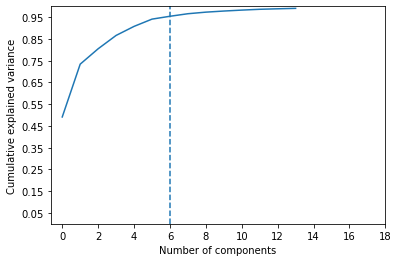

In [44]:
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

In [45]:
pca = PCA(n_components = 6)
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

6

In [46]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.49127607 0.73420187 0.80495563 0.86631146 0.90789619 0.94129982]


In [47]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1070994, 6)

In [48]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.195711,-0.366169,-0.747954,0.296501,0.168864,-0.199509
1,18.394597,71.830077,3.013230,12.242811,0.926200,-9.843453
2,-0.044600,0.219462,-0.046588,-0.203706,-0.068169,0.031379
3,0.359200,-0.190527,-0.095980,-0.129780,0.140815,-0.004940
4,62.058468,-5.568441,3.289547,-0.413877,35.482198,-9.609829


In [49]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,4.762755e-17,1.088942e-15,-1.829512e-16,1.044121e-17,-1.547268e-16,-1.186086e-16
std,4.701853e+00,3.306306e+00,1.784354e+00,1.661629e+00,1.367959e+00,1.226036e+00
min,-2.550228e-01,-4.586481e+02,-7.968048e+02,-6.034758e+02,-4.786855e+02,-4.110326e+02
25%,-1.337323e-01,-2.063879e-01,-1.256532e-02,-1.346472e-01,-7.531778e-02,-3.930969e-02
50%,-4.910363e-02,-9.340871e-02,3.172681e-03,-5.868306e-03,-1.518602e-02,-1.467571e-03
75%,1.777701e-03,1.573445e-02,2.975995e-02,6.198803e-02,1.481917e-02,6.914270e-02
max,3.764313e+03,1.771890e+03,8.579118e+02,6.786590e+02,6.007512e+02,5.262876e+02


In [50]:
#normalize data after PCA
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,4.762755e-17,1.088942e-15,-1.829512e-16,1.044121e-17,-1.547268e-16,-1.186086e-16
std,4.701853e+00,3.306306e+00,1.784354e+00,1.661629e+00,1.367959e+00,1.226036e+00
min,-2.550228e-01,-4.586481e+02,-7.968048e+02,-6.034758e+02,-4.786855e+02,-4.110326e+02
25%,-1.337323e-01,-2.063879e-01,-1.256532e-02,-1.346472e-01,-7.531778e-02,-3.930969e-02
50%,-4.910363e-02,-9.340871e-02,3.172681e-03,-5.868306e-03,-1.518602e-02,-1.467571e-03
75%,1.777701e-03,1.573445e-02,2.975995e-02,6.198803e-02,1.481917e-02,6.914270e-02
max,3.764313e+03,1.771890e+03,8.579118e+02,6.786590e+02,6.007512e+02,5.262876e+02


In [51]:
data_pca_zs.head(20)

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.254306,-0.110749,-0.419173,0.178440,0.123442,-0.162727
1,3.912202,21.725173,1.688695,7.367955,0.677067,-8.028684
2,-0.009486,0.066377,-0.026109,-0.122594,-0.049833,0.025594
3,0.076395,-0.057625,-0.053790,-0.078104,0.102938,-0.004029
4,13.198725,-1.684188,1.843551,-0.249079,25.938051,-7.838132
5,0.150263,0.084111,-0.240152,-0.034206,0.013969,0.061045
6,6.854859,-1.083682,0.981782,-0.160910,13.497502,-3.952028
7,0.377573,0.146764,-0.317032,0.019751,0.346135,-0.090649
8,-0.005343,0.048941,-0.071279,-0.037710,-0.098371,0.014575
9,0.016425,0.115661,-0.102773,-0.009062,-0.108796,-0.006771


## Unsupervised Fraud Algorithms Method 1: Heuristic Function of the zscores 

In [52]:
#calculate the fraud socre 1
p=2
oop = 1/p
score1 = (((data_pca_zs).abs()**p).sum(axis=1))**oop
score1.head(10)

0     0.571141
1    24.684917
2     0.152792
3     0.169596
4    30.244378
5     0.304004
6    15.714781
7     0.626919
8     0.137171
9     0.190195
dtype: float64

In [53]:
score1.max()

1021.8797927432358

(0.1, 2142747.525661616)

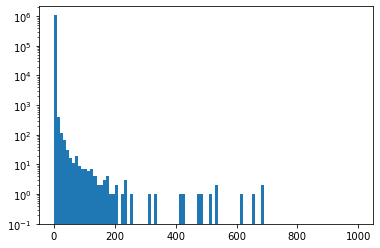

In [54]:
#Distribution Plot of the score1
plt.hist(score1, bins =100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

## Unsupervised Fraud Algorithms Method 2: Autoencoder reconstruct error

In [55]:
#construct autoencoder
from keras.models import Model
from keras.layers import Input, Dense
# placeholder for input
data_in = Input(shape=(6,))
# dimension of the encoded data. Choose 3
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(6,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [56]:
%%time
autoencoder.fit(data_pca_zs,data_pca_zs, epochs=5, shuffle=True, validation_data=(data_pca_zs,data_pca_zs))

Epoch 1/5
33469/33469 [==============================] - 75s 2ms/step - loss: 1.1754 - val_loss: 0.9753
Epoch 2/5
33469/33469 [==============================] - 74s 2ms/step - loss: 0.6971 - val_loss: 0.9748
Epoch 3/5
33469/33469 [==============================] - 73s 2ms/step - loss: 1.0266 - val_loss: 0.9745
Epoch 4/5
33469/33469 [==============================] - 78s 2ms/step - loss: 1.0433 - val_loss: 0.9744
Epoch 5/5
33469/33469 [==============================] - 73s 2ms/step - loss: 0.6074 - val_loss: 0.9744
CPU times: user 6min 10s, sys: 1min 43s, total: 7min 53s
Wall time: 6min 14s


In [57]:
#calculate the reconstruct error
%%time
pca_out = autoencoder.predict(data_pca_zs)
error = pca_out - data_pca_zs
#calculate the fraud socre 2
p=2
oop=1/p
score2 = ((error.abs()**p).sum(axis=1))**oop

CPU times: user 22.3 s, sys: 7.86 s, total: 30.1 s
Wall time: 24.1 s


In [58]:
score2.head(10)

0     0.456560
1    23.140961
2     0.012873
3     0.080882
4    29.031285
5     0.205528
6    14.850596
7     0.252982
8     0.082749
9     0.115475
dtype: float64

## Use quantile binning/rank ordering to scale each score


In [59]:
#save score1 and score2 to the dataframe
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores.head()

,score1,score2
0,0.571141,0.456560
1,24.684917,23.140961
2,0.152792,0.012873
3,0.169596,0.080882
4,30.244378,29.031285


In [60]:
#Get the rank of the two score
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(10)

,score1,score2,score1 rank,score2 rank
0,0.571141,0.456560,1046560.0,1059856.0
1,24.684917,23.140961,1070739.0,1070740.0
2,0.152792,0.012873,726630.0,118982.0
3,0.169596,0.080882,787272.0,963202.0
4,30.244378,29.031285,1070777.0,1070788.0
5,0.304004,0.205528,1015572.0,1044222.0
6,15.714781,14.850596,1070575.0,1070588.0
7,0.626919,0.252982,1049119.0,1049870.0
8,0.137171,0.082749,681219.0,967704.0
9,0.190195,0.115475,954019.0,1012990.0


In [61]:
#Combine two score
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2
scores_sorted = scores.sort_values(by='final', ascending=False)
scores_sorted.head(20)

,score1,score2,score1 rank,score2 rank,final
632815,1021.879793,1021.983910,1070994.0,1070994.0,1070994.0
776305,683.234816,681.357637,1070993.0,1070993.0,1070993.0
565391,681.029574,679.362546,1070992.0,1070992.0,1070992.0
585117,658.034211,657.414528,1070991.0,1070991.0,1070991.0
1067359,612.678099,611.102675,1070990.0,1070990.0,1070990.0
230595,534.776824,533.248176,1070989.0,1070989.0,1070989.0
85885,530.275751,528.826008,1070988.0,1070988.0,1070988.0
585438,513.047302,511.618923,1070987.0,1070987.0,1070987.0
750815,485.607884,484.090157,1070986.0,1070986.0,1070986.0
917941,470.628133,468.998774,1070985.0,1070985.0,1070985.0


In [62]:
scores_sorted.tail(10)

,score1,score2,score1 rank,score2 rank,final
732326,0.020348,0.004760,3392.0,790.0,2091.0
789950,0.018894,0.004965,2156.0,1364.0,1760.0
729849,0.016954,0.005153,1103.0,2294.0,1698.5
725720,0.016744,0.005142,1031.0,2232.0,1631.5
789534,0.020047,0.004364,3054.0,64.0,1559.0
786713,0.018458,0.004733,1896.0,712.0,1304.0
789182,0.017909,0.004709,1570.0,651.0,1110.5
789029,0.018088,0.004577,1672.0,366.0,1019.0
789332,0.016476,0.004666,919.0,546.0,732.5
789886,0.016368,0.004671,883.0,560.0,721.5


(0.1, 2142747.525661616)

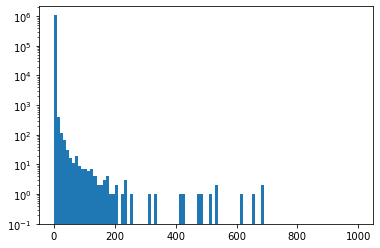

In [63]:
#Plot the distribution of the score1
plt.hist(score1, bins =100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

(0.1, 2142985.069460987)

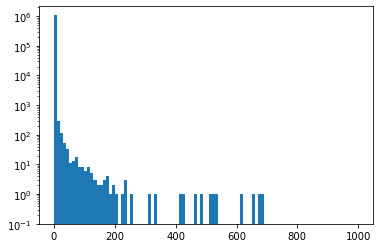

In [64]:
#Plot the distribution of the score2
plt.hist(score2, bins =100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

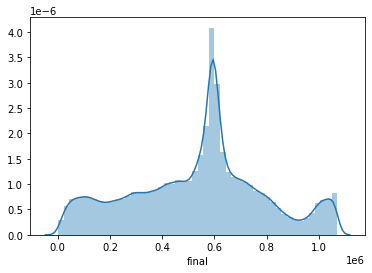

In [65]:
#Plot the distribution of the final score
sns.distplot(scores['final'])

In [66]:
#Get top 200 records index
top_records = scores.sort_values(['final'], ascending = False).head(200).index
print(top_records)

Int64Index([ 632815,  776305,  565391,  585117, 1067359,  230595,   85885,
             585438,  750815,  917941,
            ...
             921815,  696455,  899342,  917945,  935094,  162422,   56135,
             773743,  247083,  734334],
           dtype='int64', length=200)


In [67]:
#Get top 200 record
data_zs_top_n = data_zs.iloc[top_records]
data_zs_top_n.transpose()

,632815,776305,565391,585117,1067359,230595,85885,585438,750815,917941,...,921815,696455,899342,917945,935094,162422,56135,773743,247083,734334
r1,-0.013045,371.679782,237.663992,-0.129530,580.528506,3.897688e+02,-0.068212,0.016741,3.897688e+02,0.246022,...,-0.134313,-0.093645,2.278687e+01,7.197484,-0.128658,-0.143394,8.707158,0.875226,-0.135330,-0.128265
r2,377.607664,-0.001041,98.538882,443.785785,-0.007733,-5.209256e-02,141.342972,478.408776,-5.209256e-02,8.451102,...,2.810825,3.550462,-5.209256e-02,0.087014,14.233833,4.097328,25.454864,7.819390,4.073517,3.369033
r3,779.911666,0.081368,37.318672,45.762736,-0.001141,-5.838768e-02,291.982329,98.745574,-5.838768e-02,5.798971,...,5.888378,7.415864,-5.838768e-02,-0.008686,4.854969,8.545240,0.888757,8.081071,8.496066,7.041180
r4,0.364915,474.241547,729.541543,0.007548,136.327520,6.994239e+01,0.194552,0.023236,6.994239e+01,12.871515,...,-0.008338,0.109293,4.063713e+00,22.486319,0.010225,-0.035775,5.283573,1.417076,-0.011985,0.010546
r5,543.891640,0.029837,142.000319,639.195788,-0.006666,-1.213246e-02,202.732396,103.940662,-1.213246e-02,130.764583,...,4.032807,4.951692,-1.213246e-02,0.218243,20.591299,5.740633,7.207673,5.304281,5.720007,4.877438
r6,916.842517,0.062835,43.938420,53.864257,-0.004879,-1.027315e-02,341.755498,17.512421,-1.027315e-02,73.472772,...,6.810581,8.359531,-1.027315e-02,0.060812,5.777947,9.689438,0.210276,4.471413,9.654670,8.234364
r7,0.162299,664.583604,412.650431,-0.039860,134.294260,3.952919e+01,0.066557,0.213993,3.952919e+01,18.964406,...,-0.048162,0.022419,2.255119e+00,12.676162,-0.038346,-0.063922,15.296198,1.703892,-0.049925,-0.037664
r8,429.899469,0.064917,112.231732,505.230912,-0.010825,-1.944435e-02,160.956203,544.642726,-1.944435e-02,269.149100,...,3.263202,4.105141,-1.944435e-02,0.162651,16.266166,4.727645,29.039215,8.964519,4.700541,3.898618
r9,886.221750,0.159769,42.464787,52.059191,-0.006770,-1.641515e-02,331.821454,112.259919,-1.641515e-02,184.938733,...,6.752722,8.488298,-1.641515e-02,0.052297,5.578531,9.771530,1.071999,9.244127,9.715657,8.062571
r1_zip5,-0.015045,354.291542,239.487450,-0.124879,415.631636,4.434693e+02,-0.081587,0.172614,3.309789e+02,0.703170,...,-0.132514,-0.088560,4.697323e+01,15.970337,-0.124680,-0.155923,4.673376,0.811360,-0.134330,-0.136244


In [68]:
NY_data_orig.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [69]:
scores.head()

,score1,score2,score1 rank,score2 rank,final
0,0.571141,0.456560,1046560.0,1059856.0,1053208.0
1,24.684917,23.140961,1070739.0,1070740.0,1070739.5
2,0.152792,0.012873,726630.0,118982.0,422806.0
3,0.169596,0.080882,787272.0,963202.0,875237.0
4,30.244378,29.031285,1070777.0,1070788.0,1070782.5


In [70]:
#append scores to the original data
NY_data_with_scores = NY_data_orig.join(scores)
NY_data_with_scores.set_index('RECORD',inplace=True)
NY_data_with_scores.head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,...,8613000.0,NaN,FINAL,2010/11,AC-TR,0.571141,0.456560,1046560.0,1059856.0,1053208.0
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,...,80690400.0,NaN,FINAL,2010/11,AC-TR,24.684917,23.140961,1070739.0,1070740.0,1070739.5
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,...,40179510.0,NaN,FINAL,2010/11,AC-TR,0.152792,0.012873,726630.0,118982.0,422806.0
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,...,15750000.0,NaN,FINAL,2010/11,AC-TR,0.169596,0.080882,787272.0,963202.0,875237.0
5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,...,107758350.0,NaN,FINAL,2010/11,AC-TR,30.244378,29.031285,1070777.0,1070788.0,1070782.5


In [71]:
NY_data_top_n = NY_data_with_scores.sort_values(['final'], ascending = False).head(200)
NY_data_top_n

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
632816,4018420001,4,1842,1,NaN,"864163 REALTY, LLC",D9,2,157,95,...,NaN,NaN,FINAL,2010/11,AC-TR,1021.879793,1021.983910,1070994.0,1070994.0,1070994.0
776306,4080100001,4,8010,1,NaN,TONY CHEN,Q9,4,6,1,...,NaN,NaN,FINAL,2010/11,AC-TR,683.234816,681.357637,1070993.0,1070993.0,1070993.0
565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117,108,...,848484666.0,NaN,FINAL,2010/11,AC-TR,681.029574,679.362546,1070992.0,1070992.0,1070992.0
585118,4004200001,4,420,1,NaN,NEW YORK CITY ECONOMI,O3,4,298,402,...,NaN,NaN,FINAL,2010/11,AC-TR,658.034211,657.414528,1070991.0,1070991.0,1070991.0
1067360,5078530085,5,7853,85,NaN,NaN,B2,1,1,1,...,NaN,NaN,FINAL,2010/11,AC-TR,612.678099,611.102675,1070990.0,1070990.0,1070990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162423,2029410101,2,2941,101,NaN,PARKS AND RECREATION,Q1,4,812,1089,...,3123990.0,NaN,FINAL,2010/11,AC-TR,32.942237,31.168730,1070800.0,1070799.0,1070799.5
56136,1009950033,1,995,33,NaN,ONE BRYANT PARK,O4,4,201,437,...,557586900.0,NaN,FINAL,2010/11,AC-TR,32.625831,30.827951,1070798.0,1070798.0,1070798.0
773744,4078800001,4,7880,1,NaN,INDIAN CULTURAL AND C,I1,4,403,309,...,NaN,NaN,FINAL,2010/11,AC-TR,32.554291,30.689792,1070797.0,1070797.0,1070797.0


In [72]:
data_zs_top_n['RECORD'] = (data_zs_top_n.index + 1).astype(int)
data_zs_top_n.set_index('RECORD',inplace=True)
data_zs_top_n

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
RECORD,,,,,,,,,,,,,,,,,,,,,
632816,-0.013045,377.607664,779.911666,0.364915,543.891640,916.842517,0.162299,429.899469,886.221750,-0.015045,...,1025.797319,0.016012,360.944440,625.129485,0.456027,531.101586,910.945692,0.251413,426.496762,885.746210
776306,371.679782,-0.001041,0.081368,474.241547,0.029837,0.062835,664.583604,0.064917,0.159769,354.291542,...,0.014873,367.224421,-0.008962,0.053489,560.067085,0.026760,0.059738,842.991287,0.064105,0.156597
565392,237.663992,98.538882,37.318672,729.541543,142.000319,43.938420,412.650431,112.231732,42.464787,239.487450,...,6.510394,166.215003,101.147187,34.833107,763.653863,270.990425,85.635619,405.070321,172.918765,68.151447
585118,-0.129530,443.785785,45.762736,0.007548,639.195788,53.864257,-0.039860,505.230912,52.059191,-0.124879,...,7.983520,-0.099067,424.203622,36.669566,0.034004,624.164996,53.515286,-0.005002,501.232000,52.028351
1067360,580.528506,-0.007733,-0.001141,136.327520,-0.006666,-0.004879,134.294260,-0.010825,-0.006770,415.631636,...,0.000283,616.427795,-0.001463,-0.004413,101.457248,-0.006028,-0.005014,103.481923,-0.006302,-0.005896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162423,-0.143394,4.097328,8.545240,-0.035775,5.740633,9.689438,-0.063922,4.727645,9.771530,-0.155923,...,1.490664,-0.111451,6.351906,10.956753,-0.015368,10.307541,13.959067,-0.037186,6.861645,12.695322
56136,8.707158,25.454864,0.888757,5.283573,7.207673,0.210276,15.296198,29.039215,1.071999,4.673376,...,0.154937,4.116112,28.339724,1.684481,1.216754,4.404774,0.179058,2.966764,13.000697,0.931812
773744,0.875226,7.819390,8.081071,1.417076,5.304281,4.471413,1.703892,8.964519,9.244127,0.811360,...,1.409687,0.893566,7.466531,6.465682,1.698546,5.177195,4.439975,2.206741,8.893272,9.236112


In [73]:
NY_data_top_n.to_csv('NY_top.csv', index=True)
data_zs_top_n.to_csv('data_zs_top.csv', index=True)

## Heatmap of the variable Z-score of top 20 properties with highest scores

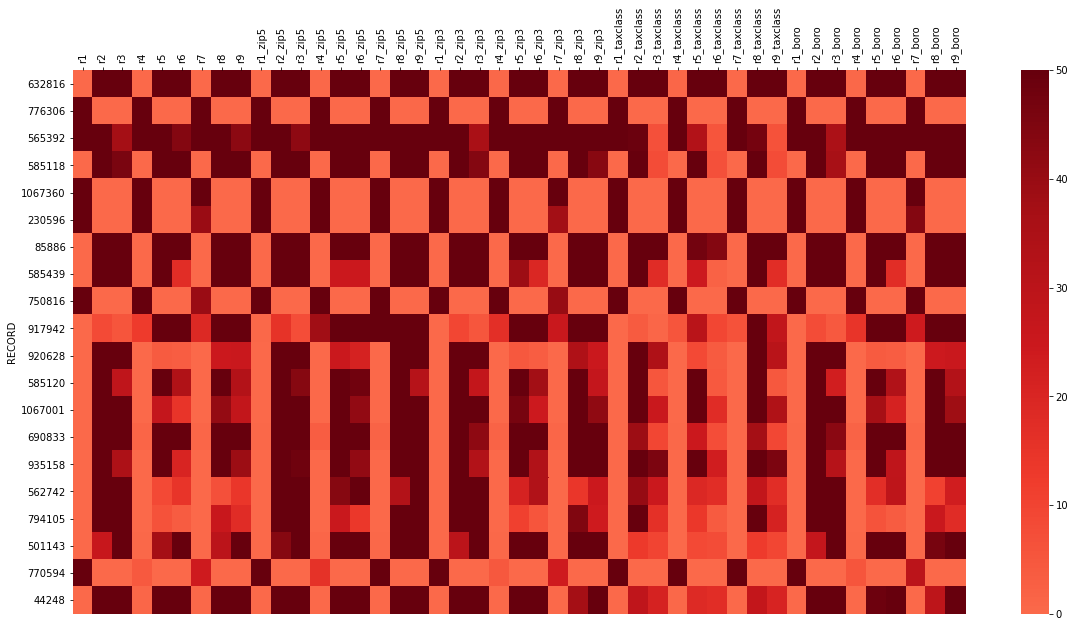

In [74]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(20)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [75]:
print('Duration: ', datetime.now() - start_time)

Duration:  0:12:18.116128
